# Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

# Para o Modelo
import tensorflow as tf
import keras
from keras import backend as K
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.optimizers import *
from keras.callbacks import *
from keras.metrics import top_k_categorical_accuracy
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score

Using TensorFlow backend.


In [3]:
images = dict()

# Função para leitura dos espectros

In [4]:
def obtem_dados_dos_canais(linhas):
    dados = []
    pode_comecar = False
    for linha in linhas:
        if linha == "A004USERDEFINED                                                     \n":
            pode_comecar = True
            continue
        if pode_comecar:
            aux = linha.strip().split()
            if int(aux[1]) % 5:
                print("oi!")
            dados.extend([float(x) for x in aux[2:]])
    return dados[1:]

# Arquivos de entrada

In [5]:
arquivos = ['Am-241 - BG.IEC', 'Ba-133 - BG.IEC', 'Cd-109 - BG.IEC', 'Co-57 - BG.IEC', 'Co-60 - BG.IEC',
            'Cs-137 - BG.IEC', 'Eu-152 - BG.IEC', 'Mn-54 - BG.IEC', 'Na-22 - BG.IEC', 'Pb-210 - BG.IEC',]

df_nuclideos = dict()
img_espectros = dict()
img_convertidos = dict()


for arquivo in arquivos:
    print(arquivo)
    dados = []

    with open('../Espectros/{0}'.format(arquivo), 'r') as f:
        dados = f.readlines()
    dados = obtem_dados_dos_canais(dados)
    df = pd.DataFrame({'channel': range(0, len(dados)), 'counts' : dados})
    df_nuclideos[arquivo] = df.copy()
    img_convertidos[arquivo] = np.array(dados).reshape((128, 128)).copy()
    images[arquivo.split(' ')[0]] = np.array(dados).reshape((128, 128)).copy()

Am-241 - BG.IEC
Ba-133 - BG.IEC
Cd-109 - BG.IEC
Co-57 - BG.IEC
Co-60 - BG.IEC
Cs-137 - BG.IEC
Eu-152 - BG.IEC
Mn-54 - BG.IEC
Na-22 - BG.IEC
Pb-210 - BG.IEC


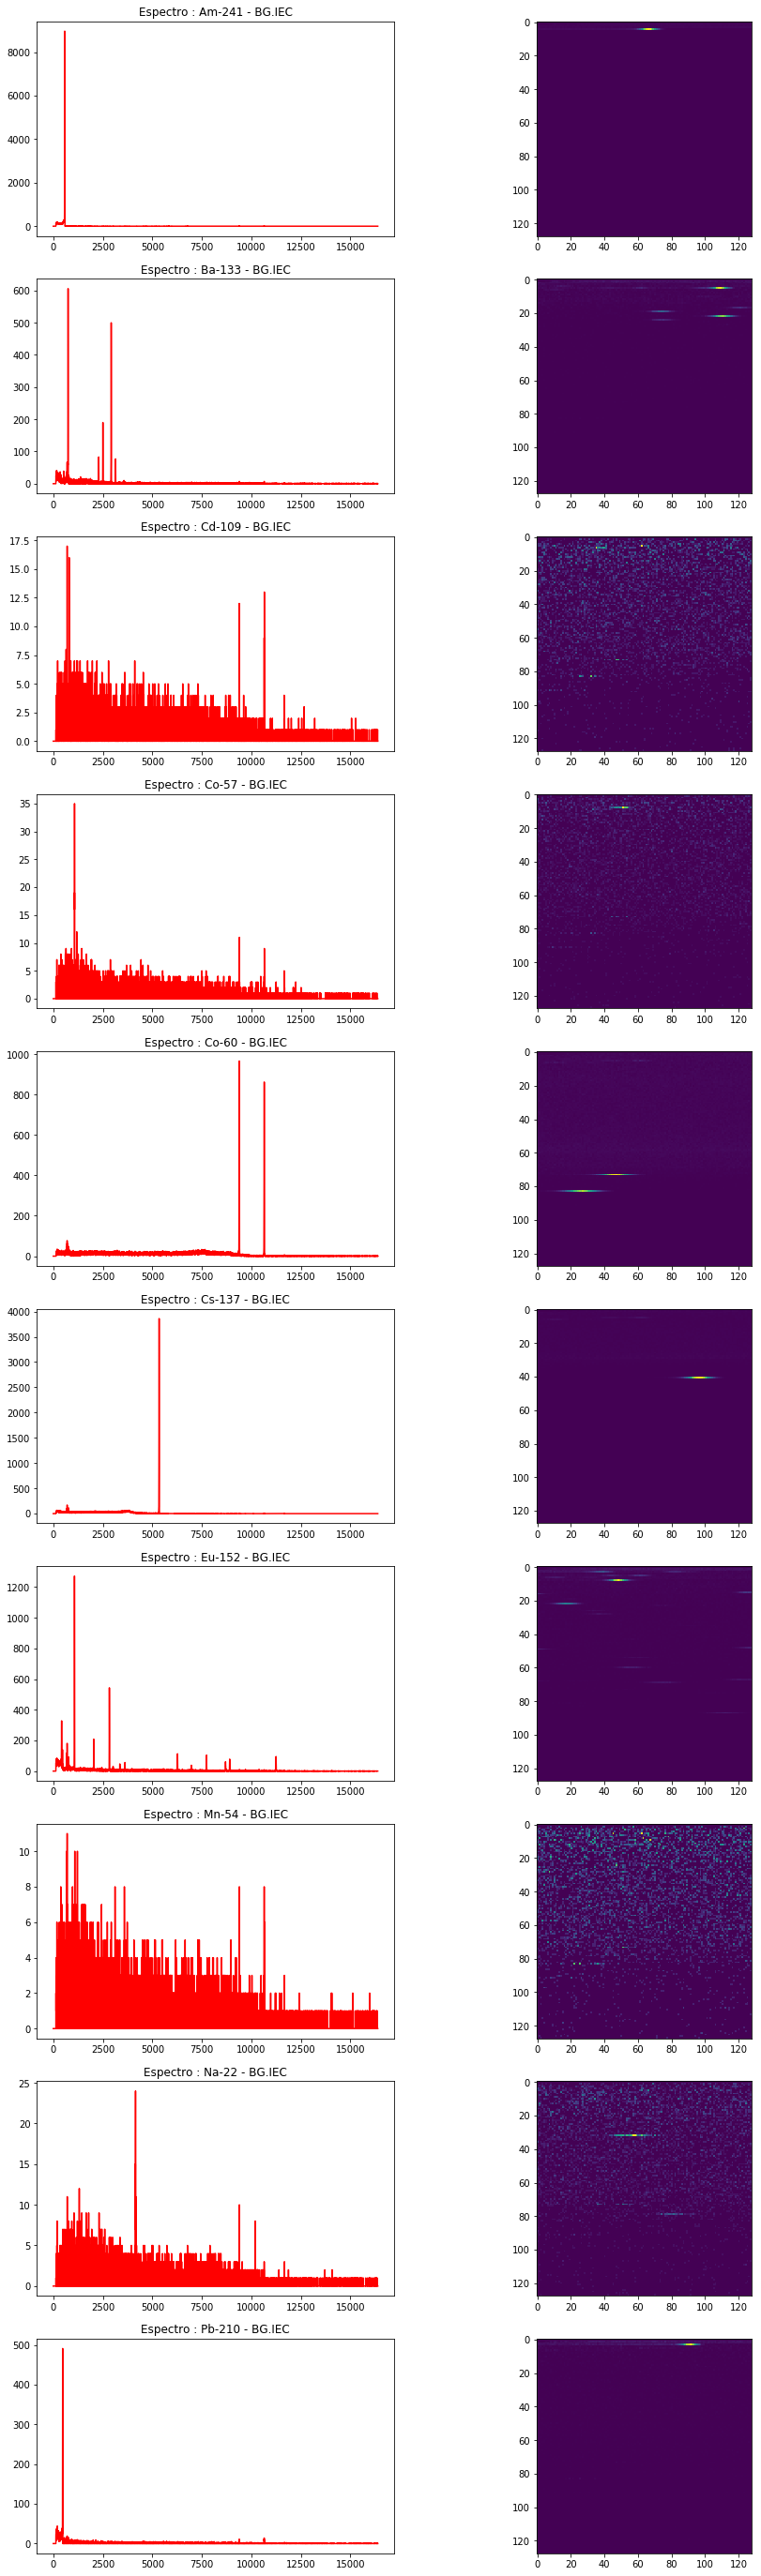

In [5]:
f, axarr = plt.subplots(10, 2, figsize=(15,25))
for n, arquivo in enumerate(arquivos):
    df = df_nuclideos[arquivo]
    axarr[n, 0].plot(df['channel'], df['counts'], 'r')
    axarr[n, 0].set_title("Espectro : {0}".format(arquivo))
    
    axarr[n, 1].imshow(img_convertidos[arquivo])
    #axarr[n, 1].set_title("Como Imagem : {0}".format(arquivo))
    
plt.grid(False)
plt.subplots_adjust(bottom=1.25, top=2.75)
plt.show()

# Rede neural para classificação

Precisamos criar os seguntes componentes:

- Gerador de Imagens : para alimentar a rede neural com os espectros acima adicionando algum ruido Gaussiano

- Rede Neural VGG 19 com 1 saídas possiveis: [COLOCA A LISTA AQUI!]

Depois procedemos com o treino e com a validação.


In [6]:
arquivo_por_nome = { b : b.split()[0] for a, b in enumerate(list(img_convertidos.keys()))}
nome_por_arquivo = { b.split()[0] : b for a, b in enumerate(list(img_convertidos.keys()))}

id_para_radionuclideos = { a : b.split()[0] for a, b in enumerate(list(img_convertidos.keys()))}
radionuclideos = { b.split()[0] : a for a, b in enumerate(list(img_convertidos.keys()))}
arquivo_por_nome, nome_por_arquivo, id_para_radionuclideos, radionuclideos

({'Am-241 - BG.IEC': 'Am-241',
  'Ba-133 - BG.IEC': 'Ba-133',
  'Cd-109 - BG.IEC': 'Cd-109',
  'Co-57 - BG.IEC': 'Co-57',
  'Co-60 - BG.IEC': 'Co-60',
  'Cs-137 - BG.IEC': 'Cs-137',
  'Eu-152 - BG.IEC': 'Eu-152',
  'Mn-54 - BG.IEC': 'Mn-54',
  'Na-22 - BG.IEC': 'Na-22',
  'Pb-210 - BG.IEC': 'Pb-210'},
 {'Am-241': 'Am-241 - BG.IEC',
  'Ba-133': 'Ba-133 - BG.IEC',
  'Cd-109': 'Cd-109 - BG.IEC',
  'Co-57': 'Co-57 - BG.IEC',
  'Co-60': 'Co-60 - BG.IEC',
  'Cs-137': 'Cs-137 - BG.IEC',
  'Eu-152': 'Eu-152 - BG.IEC',
  'Mn-54': 'Mn-54 - BG.IEC',
  'Na-22': 'Na-22 - BG.IEC',
  'Pb-210': 'Pb-210 - BG.IEC'},
 {0: 'Am-241',
  1: 'Ba-133',
  2: 'Cd-109',
  3: 'Co-57',
  4: 'Co-60',
  5: 'Cs-137',
  6: 'Eu-152',
  7: 'Mn-54',
  8: 'Na-22',
  9: 'Pb-210'},
 {'Am-241': 0,
  'Ba-133': 1,
  'Cd-109': 2,
  'Co-57': 3,
  'Co-60': 4,
  'Cs-137': 5,
  'Eu-152': 6,
  'Mn-54': 7,
  'Na-22': 8,
  'Pb-210': 9})

In [7]:
def add_noise(image):
    #if random.random() <= 0.5:
    #    return image.reshape((128, 128, 1))
    row,col = image.shape
    mean = 1 #np.mean(image)
    var = 0.1 #random.random() #
    sigma = var**0.5
    gauss = np.random.normal(mean, sigma, (row,col))
    gauss = gauss.reshape(row, col)
    noisy = image + gauss
    return noisy.reshape((128, 128, 1)) #/ np.max(noisy) # normalizando pelo valor máximo

In [8]:
def gera_imagem_combinada(dicionario_imagens, n_combinacoes=3):
    assert n_combinacoes <= 10, "No máximo 10 combinações"
    a = np.random.choice(10, n_combinacoes, replace=False).tolist()
    label = np.sum([to_categorical(x, 10) for x in a], axis=0)
    img = np.sum([add_noise(dicionario_imagens[id_para_radionuclideos[x]]) for x in a], axis=0)
    
    return img, label

In [9]:
learning_rate = 1e-3
epochs = 250

In [10]:
def accuracy_score_wrapper(label, pred):
    threshold = .5
    label = (label >= threshold).astype(np.uint8)
    pred = (pred >= threshold).astype(np.uint8)
    return np.float32(accuracy_score(label, pred))

In [11]:
def my_accuracy_score(label, pred):
    metric_value = tf.py_func(accuracy_score_wrapper, [label, pred], tf.float32)
    return metric_value

In [12]:
K.clear_session()

vgg_model = VGG19(include_top=False, weights=None, input_shape=(128, 128, 1), classes=10)

x = keras.layers.Flatten()(vgg_model.output)
x = keras.layers.Dense(4096, activation='relu')(x)
x = keras.layers.Dense(4096, activation='relu')(x)
x = keras.layers.Dense(10, activation='sigmoid', name="predictions")(x)

model = keras.models.Model(vgg_model.input, x)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 1)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      640       
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
bloc

In [13]:
opt = SGD(lr=learning_rate, nesterov=True, momentum=0.9)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[my_accuracy_score])

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    


In [14]:
#from IPython.display import SVG
#from keras.utils import plot_model
#from keras.utils.vis_utils import model_to_dot
#plot_model(model, to_file='model.png')
#SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [2]:
x_train = np.load("../data/x_train.npz")
x_train_val = np.load("../data/x_train_val.npz")

y_train = np.load("../data/y_train.npz")
y_train_val = np.load("../data/y_train_val.npz")

In [16]:
callbacks = []

hist = model.fit(x_train, y_train,
                 epochs=epochs,
                 verbose=2,
                 batch_size=8,
                 callbacks=callbacks,
                 validation_data=(x_train_val, y_train_val))

Instructions for updating:
Use tf.cast instead.
Train on 500 samples, validate on 160 samples
Epoch 1/250
 - 14s - loss: 0.6010 - my_accuracy_score: 0.0900 - val_loss: 0.5596 - val_my_accuracy_score: 0.1250
Epoch 2/250
 - 9s - loss: 0.5449 - my_accuracy_score: 0.1560 - val_loss: 0.5310 - val_my_accuracy_score: 0.1812
Epoch 3/250
 - 9s - loss: 0.5142 - my_accuracy_score: 0.1800 - val_loss: 0.5061 - val_my_accuracy_score: 0.1437
Epoch 4/250
 - 9s - loss: 0.4923 - my_accuracy_score: 0.2040 - val_loss: 0.4950 - val_my_accuracy_score: 0.1313
Epoch 5/250
 - 9s - loss: 0.4777 - my_accuracy_score: 0.1840 - val_loss: 0.4761 - val_my_accuracy_score: 0.1500
Epoch 6/250
 - 9s - loss: 0.4550 - my_accuracy_score: 0.2100 - val_loss: 0.4468 - val_my_accuracy_score: 0.1812
Epoch 7/250
 - 9s - loss: 0.4464 - my_accuracy_score: 0.2020 - val_loss: 0.4679 - val_my_accuracy_score: 0.1437
Epoch 8/250
 - 9s - loss: 0.4285 - my_accuracy_score: 0.2160 - val_loss: 0.4172 - val_my_accuracy_score: 0.1938
Epoch 9/2

Epoch 71/250
 - 9s - loss: 0.0690 - my_accuracy_score: 0.7620 - val_loss: 0.1301 - val_my_accuracy_score: 0.6312
Epoch 72/250
 - 9s - loss: 0.0692 - my_accuracy_score: 0.7620 - val_loss: 0.1513 - val_my_accuracy_score: 0.7000
Epoch 73/250
 - 9s - loss: 0.0706 - my_accuracy_score: 0.7900 - val_loss: 0.1571 - val_my_accuracy_score: 0.6250
Epoch 74/250
 - 9s - loss: 0.0645 - my_accuracy_score: 0.7840 - val_loss: 0.1441 - val_my_accuracy_score: 0.6312
Epoch 75/250
 - 9s - loss: 0.0675 - my_accuracy_score: 0.7820 - val_loss: 0.1315 - val_my_accuracy_score: 0.6500
Epoch 76/250
 - 9s - loss: 0.0640 - my_accuracy_score: 0.7860 - val_loss: 0.1496 - val_my_accuracy_score: 0.6438
Epoch 77/250
 - 9s - loss: 0.0611 - my_accuracy_score: 0.7960 - val_loss: 0.1183 - val_my_accuracy_score: 0.7000
Epoch 78/250
 - 9s - loss: 0.0656 - my_accuracy_score: 0.8060 - val_loss: 0.1694 - val_my_accuracy_score: 0.6125
Epoch 79/250
 - 9s - loss: 0.0725 - my_accuracy_score: 0.7640 - val_loss: 0.1474 - val_my_accura

 - 9s - loss: 0.0210 - my_accuracy_score: 0.9320 - val_loss: 0.1241 - val_my_accuracy_score: 0.7375
Epoch 144/250
 - 9s - loss: 0.0157 - my_accuracy_score: 0.9660 - val_loss: 0.1743 - val_my_accuracy_score: 0.7375
Epoch 145/250
 - 9s - loss: 0.0158 - my_accuracy_score: 0.9580 - val_loss: 0.1233 - val_my_accuracy_score: 0.7688
Epoch 146/250
 - 9s - loss: 0.0135 - my_accuracy_score: 0.9680 - val_loss: 0.2068 - val_my_accuracy_score: 0.6750
Epoch 147/250
 - 9s - loss: 0.0159 - my_accuracy_score: 0.9460 - val_loss: 0.1317 - val_my_accuracy_score: 0.8000
Epoch 148/250
 - 9s - loss: 0.0105 - my_accuracy_score: 0.9700 - val_loss: 0.2037 - val_my_accuracy_score: 0.7688
Epoch 149/250
 - 9s - loss: 0.0153 - my_accuracy_score: 0.9580 - val_loss: 0.1259 - val_my_accuracy_score: 0.7562
Epoch 150/250
 - 9s - loss: 0.0099 - my_accuracy_score: 0.9720 - val_loss: 0.1158 - val_my_accuracy_score: 0.7812
Epoch 151/250
 - 9s - loss: 0.0124 - my_accuracy_score: 0.9640 - val_loss: 0.1423 - val_my_accuracy_sc

Epoch 215/250
 - 9s - loss: 0.0090 - my_accuracy_score: 0.9820 - val_loss: 0.1700 - val_my_accuracy_score: 0.8000
Epoch 216/250
 - 9s - loss: 0.0040 - my_accuracy_score: 0.9860 - val_loss: 0.1677 - val_my_accuracy_score: 0.8250
Epoch 217/250
 - 9s - loss: 0.0013 - my_accuracy_score: 0.9960 - val_loss: 0.1753 - val_my_accuracy_score: 0.8313
Epoch 218/250
 - 9s - loss: 0.0044 - my_accuracy_score: 0.9900 - val_loss: 0.2486 - val_my_accuracy_score: 0.7875
Epoch 219/250
 - 9s - loss: 0.0030 - my_accuracy_score: 0.9940 - val_loss: 0.1761 - val_my_accuracy_score: 0.8000
Epoch 220/250
 - 9s - loss: 0.0053 - my_accuracy_score: 0.9880 - val_loss: 0.1489 - val_my_accuracy_score: 0.8187
Epoch 221/250
 - 9s - loss: 0.0106 - my_accuracy_score: 0.9760 - val_loss: 0.2106 - val_my_accuracy_score: 0.7812
Epoch 222/250
 - 9s - loss: 0.0064 - my_accuracy_score: 0.9780 - val_loss: 0.2484 - val_my_accuracy_score: 0.7875
Epoch 223/250
 - 9s - loss: 0.0171 - my_accuracy_score: 0.9520 - val_loss: 0.1450 - val_

In [17]:
from keras.models import save_model
save_model(model, 'VGG19-SGD-Nesterov-Sigmoid.hdf5')

In [ ]:
K.clear_session()

import tensorflow as tf
from keras import backend as K

num_cores = 4
GPU = False
CPU = not GPU
if GPU:
    num_GPU = 1
    num_CPU = 1
if CPU:
    num_CPU = 1
    num_GPU = 0

config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,
                        inter_op_parallelism_threads=num_cores, 
                        allow_soft_placement=True,
                        device_count = {'CPU' : num_CPU,
                                        'GPU' : num_GPU}
                       )

session = tf.Session(config=config)
K.set_session(session)

In [24]:
def my_(y_true, y_pred):
    return keras.metrics.top_k_categorical_accuracy(y_true, y_pred, k=3)

In [25]:
from keras.models import load_model
model = load_model('VGG19-SGD-Nesterov-Sigmoid.hdf5',
                   custom_objects={'my_accuracy_score': my_})
model.evaluate(x_train_val, y_train_val)

160/160 [==============================] - 7s 45ms/step


[0.22796055674552917, 0.975]

In [27]:
model2 = load_model('../VGG-16/VGG16-SGD-Nesterov-Sigmoid.hdf5',
                   custom_objects={'my_accuracy_score': my_})
model2.evaluate(x_train_val, y_train_val)

160/160 [==============================] - 6s 39ms/step


[0.2150476187467575, 0.9625]

In [1]:
model.metrics

NameError: name 'model' is not defined

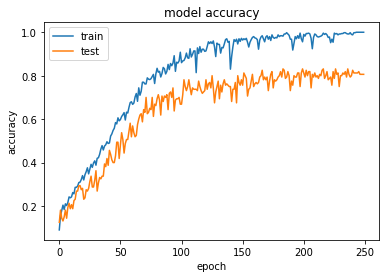

In [18]:
plt.plot(hist.history['my_accuracy_score'])
plt.plot(hist.history['val_my_accuracy_score'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

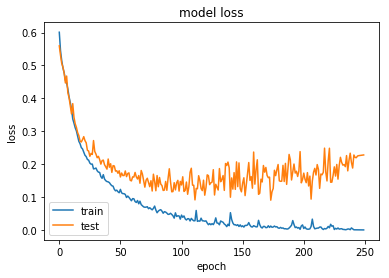

In [19]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower left')
plt.show()

In [20]:
pred = model.predict(np.array([images['Am-241'].reshape((128, 128, 1))]))
df = pd.DataFrame({'radionuclideo':list(radionuclideos.keys()), 'score': np.around(pred[0]*100,decimals=4)})
df

,radionuclideo,score
0,Am-241,100.0000
1,Ba-133,0.0000
2,Cd-109,0.0000
3,Co-57,0.0000
4,Co-60,0.0000
5,Cs-137,0.0001
6,Eu-152,0.0000
7,Mn-54,0.0000
8,Na-22,0.0000
9,Pb-210,0.0000


In [21]:
pred = model.predict(np.array([images['Ba-133'].reshape((128, 128, 1))]))
df = pd.DataFrame({'radionuclideo':list(radionuclideos.keys()), 'score': np.around(pred[0]*100,decimals=4)})
df

,radionuclideo,score
0,Am-241,0.0
1,Ba-133,100.0
2,Cd-109,0.0
3,Co-57,0.0
4,Co-60,0.0
5,Cs-137,0.0
6,Eu-152,0.0
7,Mn-54,0.0
8,Na-22,0.0
9,Pb-210,0.0


In [22]:
pred = model.predict(np.array([images['Cd-109'].reshape((128, 128, 1))]))
df = pd.DataFrame({'radionuclideo':list(radionuclideos.keys()), 'score': np.around(pred[0]*100,decimals=4)})
df

,radionuclideo,score
0,Am-241,0.0
1,Ba-133,0.0
2,Cd-109,100.0
3,Co-57,0.0
4,Co-60,0.0
5,Cs-137,0.0
6,Eu-152,0.0
7,Mn-54,0.0
8,Na-22,0.0
9,Pb-210,0.0


In [23]:
pred = model.predict(np.array([images['Co-57'].reshape((128, 128, 1))]))
df = pd.DataFrame({'radionuclideo':list(radionuclideos.keys()), 'score': np.around(pred[0]*100,decimals=4)})
df

,radionuclideo,score
0,Am-241,0.000000
1,Ba-133,0.000000
2,Cd-109,0.000000
3,Co-57,99.996803
4,Co-60,0.000000
5,Cs-137,0.000000
6,Eu-152,0.000000
7,Mn-54,0.789300
8,Na-22,0.000000
9,Pb-210,0.000000


In [24]:
pred = model.predict(np.array([images['Co-60'].reshape((128, 128, 1))]))
df = pd.DataFrame({'radionuclideo':list(radionuclideos.keys()), 'score': np.around(pred[0]*100,decimals=4)})
df

,radionuclideo,score
0,Am-241,0.0
1,Ba-133,0.0
2,Cd-109,0.0
3,Co-57,0.0
4,Co-60,100.0
5,Cs-137,0.0
6,Eu-152,0.0
7,Mn-54,0.0
8,Na-22,0.0
9,Pb-210,0.0


In [25]:
pred = model.predict(np.array([images['Cs-137'].reshape((128, 128, 1))]))
df = pd.DataFrame({'radionuclideo':list(radionuclideos.keys()), 'score': np.around(pred[0]*100,decimals=4)})
df

,radionuclideo,score
0,Am-241,0.0
1,Ba-133,0.0
2,Cd-109,0.0
3,Co-57,0.0
4,Co-60,0.0
5,Cs-137,100.0
6,Eu-152,0.0
7,Mn-54,0.0
8,Na-22,0.0
9,Pb-210,0.0


In [26]:
pred = model.predict(np.array([images['Eu-152'].reshape((128, 128, 1))]))
df = pd.DataFrame({'radionuclideo':list(radionuclideos.keys()), 'score': np.around(pred[0]*100,decimals=4)})
df

,radionuclideo,score
0,Am-241,0.0000
1,Ba-133,0.0000
2,Cd-109,0.0000
3,Co-57,0.0146
4,Co-60,0.0000
5,Cs-137,91.7911
6,Eu-152,100.0000
7,Mn-54,0.0000
8,Na-22,0.0000
9,Pb-210,0.0000


In [27]:
pred = model.predict(np.array([images['Mn-54'].reshape((128, 128, 1))]))
df = pd.DataFrame({'radionuclideo':list(radionuclideos.keys()), 'score': np.around(pred[0]*100,decimals=4)})
df

,radionuclideo,score
0,Am-241,0.0
1,Ba-133,0.0
2,Cd-109,0.0
3,Co-57,0.0
4,Co-60,0.0
5,Cs-137,0.0
6,Eu-152,0.0
7,Mn-54,100.0
8,Na-22,0.0
9,Pb-210,0.0


In [28]:
pred = model.predict(np.array([images['Na-22'].reshape((128, 128, 1))]))
df = pd.DataFrame({'radionuclideo':list(radionuclideos.keys()), 'score': np.around(pred[0]*100,decimals=4)})
df

,radionuclideo,score
0,Am-241,0.000000
1,Ba-133,0.000000
2,Cd-109,0.001100
3,Co-57,0.000000
4,Co-60,0.000000
5,Cs-137,0.000000
6,Eu-152,0.000000
7,Mn-54,82.944702
8,Na-22,0.027500
9,Pb-210,0.000000


In [29]:
pred = model.predict(np.array([images['Pb-210'].reshape((128, 128, 1))]))
df = pd.DataFrame({'radionuclideo':list(radionuclideos.keys()), 'score': np.around(pred[0]*100,decimals=4)})
df

,radionuclideo,score
0,Am-241,0.0
1,Ba-133,0.0
2,Cd-109,0.0
3,Co-57,0.0
4,Co-60,0.0
5,Cs-137,0.0
6,Eu-152,0.0
7,Mn-54,0.0
8,Na-22,0.0
9,Pb-210,100.0


In [30]:
pd.options.display.float_format = '{:,.4f}%'.format

co60_com_am241 = images['Co-60'] + images['Am-241']
pred = model.predict(np.array([co60_com_am241.reshape((128, 128, 1))]))
df = pd.DataFrame({'radionuclideo':list(radionuclideos.keys()), 'score': np.around(pred[0]*100,decimals=4)})
df

,radionuclideo,score
0,Am-241,99.9999%
1,Ba-133,0.0000%
2,Cd-109,0.0000%
3,Co-57,0.0000%
4,Co-60,99.9984%
5,Cs-137,0.0000%
6,Eu-152,0.0000%
7,Mn-54,0.0000%
8,Na-22,0.0000%
9,Pb-210,0.0000%


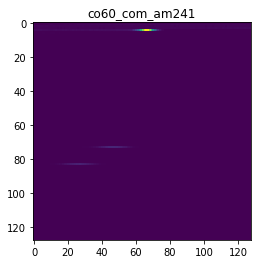

In [31]:
plt.imshow(co60_com_am241)
plt.title('co60_com_am241')
plt.show()

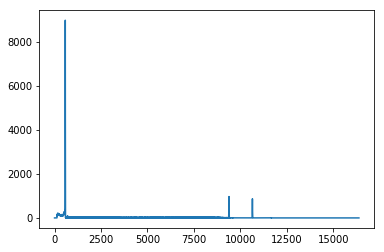

In [32]:
plt.plot(co60_com_am241.reshape((128*128)))
plt.show()

In [33]:
eu152_com_am241 = images['Eu-152'] + images['Am-241']
pred = model.predict(np.array([eu152_com_am241.reshape((128, 128, 1))]))
df = pd.DataFrame({'radionuclideo':list(radionuclideos.keys()), 'score': np.around(pred[0]*100,decimals=4)})
df

,radionuclideo,score
0,Am-241,100.0000%
1,Ba-133,0.0000%
2,Cd-109,0.0000%
3,Co-57,0.0000%
4,Co-60,0.0000%
5,Cs-137,0.0000%
6,Eu-152,93.7178%
7,Mn-54,0.0000%
8,Na-22,0.0000%
9,Pb-210,0.0000%


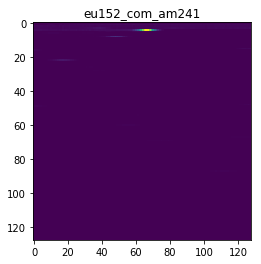

In [34]:
plt.imshow(eu152_com_am241)
plt.title('eu152_com_am241')
plt.show()

In [35]:
cs137_com_pb210 = images['Cs-137'] + images['Pb-210']

pred = model.predict(np.array([cs137_com_pb210.reshape((128, 128, 1))]))
df = pd.DataFrame({'radionuclideo':list(radionuclideos.keys()), 'score': np.around(pred[0]*100,decimals=4)})
df

,radionuclideo,score
0,Am-241,0.0000%
1,Ba-133,0.0000%
2,Cd-109,0.0000%
3,Co-57,0.0000%
4,Co-60,0.0000%
5,Cs-137,100.0000%
6,Eu-152,0.0000%
7,Mn-54,0.0000%
8,Na-22,0.0000%
9,Pb-210,100.0000%


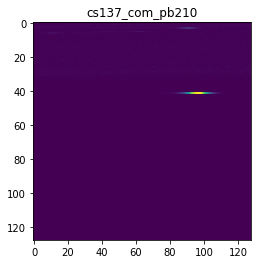

In [36]:
plt.imshow(cs137_com_pb210)
plt.title('cs137_com_pb210')
plt.show()

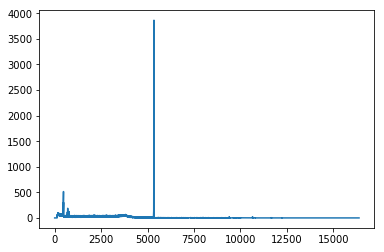

In [37]:
plt.plot(cs137_com_pb210.reshape((128*128)))
plt.show()

In [38]:
cs137_com_co60_com_am241 = images['Cs-137'] + images['Co-60'] + images['Am-241']

pred = model.predict(np.array([cs137_com_co60_com_am241.reshape((128, 128, 1))]))
df = pd.DataFrame({'radionuclideo':list(radionuclideos.keys()), 'score': np.around(pred[0]*100,decimals=4)})
df

,radionuclideo,score
0,Am-241,99.5764%
1,Ba-133,0.0000%
2,Cd-109,0.0000%
3,Co-57,0.0000%
4,Co-60,94.9724%
5,Cs-137,100.0000%
6,Eu-152,0.0000%
7,Mn-54,0.0000%
8,Na-22,0.0000%
9,Pb-210,0.0000%


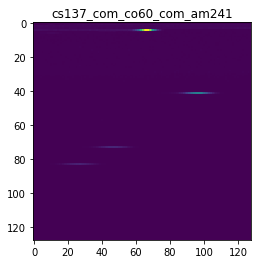

In [39]:
plt.imshow(cs137_com_co60_com_am241)
plt.title('cs137_com_co60_com_am241')
plt.show()

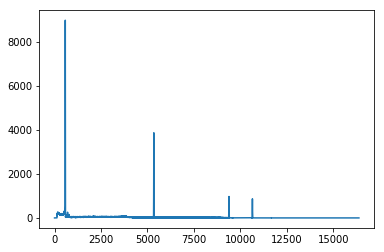

In [40]:
plt.plot(cs137_com_co60_com_am241.reshape((128*128)))
plt.show()

# Testando com a leitura de calibração (Am, Cs, Co)

Esse espectro não passou pelo treino, então é a 1a vez que a rede enxerga isso.



In [41]:
dados = []

with open('../Espectros/Am-Cs-Co - BG.IEC', 'r') as f:
    dados = f.readlines()
dados = obtem_dados_dos_canais(dados)
df = pd.DataFrame({'channel': range(0, len(dados)), 'counts' : dados})

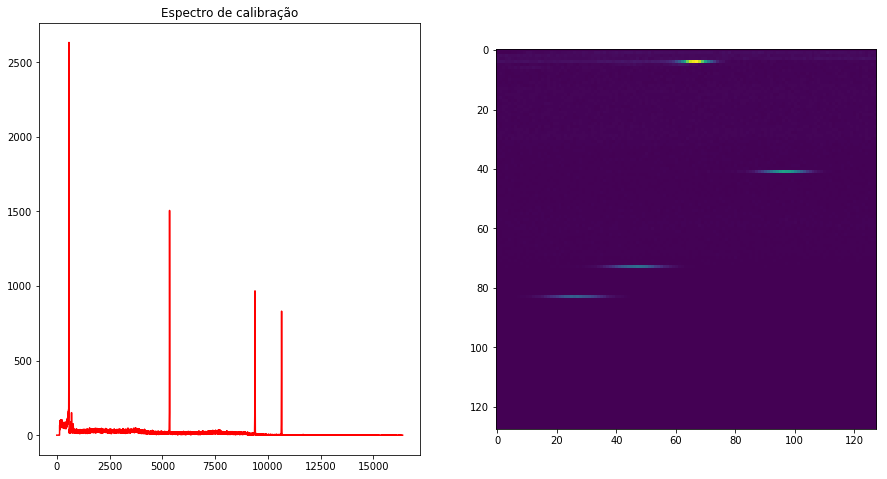

In [42]:
f, axarr = plt.subplots(1, 2, figsize=(15, 4))
axarr[0].plot(df['channel'], df['counts'], 'r')
axarr[0].set_title("Espectro de calibração")
axarr[1].imshow(np.array(dados).reshape((128,128)))

plt.grid(False)
plt.subplots_adjust(bottom=1.25, top=2.75)
plt.show()

In [43]:
dados = np.array(dados)
pred = model.predict(np.array([dados.reshape((128, 128, 1))]))
df = pd.DataFrame({'radionuclideo':list(radionuclideos.keys()), 'score': np.around(pred[0]*100,decimals=4)})
df

,radionuclideo,score
0,Am-241,38.5441%
1,Ba-133,0.0000%
2,Cd-109,0.0000%
3,Co-57,0.0000%
4,Co-60,96.7208%
5,Cs-137,100.0000%
6,Eu-152,0.0000%
7,Mn-54,0.0000%
8,Na-22,0.0000%
9,Pb-210,0.0000%
